In [133]:
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [134]:
# 计算成对的欧式距离
def pairwise_distances(Data):
    dist_matrix = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    return dist_matrix

# 计算kNN图的邻接矩阵
def nearest_neighbors(Data, n_neighbors):
    dist_matrix = pairwise_distances(Data)
    adjacency_matrix = dist_matrix.argsort(axis=1)[:, 1:n_neighbors+1]
    #np.savetxt('adjacency_matrix.txt', adjacency_matrix, delimiter=',')
    return adjacency_matrix

In [135]:
# 计算每个数据点的平均邻域半径
def compute_average_radius(Data):
    n = Data.shape[0]
    distances = pairwise_distances(Data)
    average_radius = np.zeros(n)
    for i in range(n):
        avg_radius = np.mean(distances[i])
        average_radius[i] = avg_radius
    np.savetxt('distances.csv', distances, delimiter=',')
    np.savetxt('average_radius.csv', average_radius, delimiter=',')
    return average_radius


# 构建epsilon邻域的邻接矩阵
def epsilon_neighborhood(Data, epsilon):
    n_samples = Data.shape[0]
    adjacency_matrix = np.zeros((n_samples, n_samples), dtype=int)
    for i in range(n_samples):
        distances = np.sqrt(np.sum((Data[i] - Data) ** 2, axis=1))
        neighbors = np.where(distances <= epsilon)[0]
        adjacency_matrix[i, neighbors] = 1
        adjacency_matrix[neighbors, i] = 1
    #np.savetxt('adjacency_matrix.txt', adjacency_matrix, delimiter=',')
    return adjacency_matrix

In [136]:
# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, n_neighbors, t):
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    if method == 'knn':
        dist_matrix = pairwise_distances(Data)  # 计算数据集中样本点之间的距离
        #np.savetxt('dist_matrix.csv', dist_matrix, delimiter=',')
        knn_matrix = nearest_neighbors(Data, n_neighbors)  # 计算每个样本点的 n_neighbors 个最近邻索引
        #np.savetxt('knn_matrix.csv', knn_matrix, delimiter=',')
        for i in range(len(Data)):  # 对于数据集中的每个样本点 i
            for j in knn_matrix[i]:  # 对于样本点 i 的 n_neighbors 个最近邻点 j
                Weight_matrix[i][int(j)] = np.exp(- dist_matrix[i][int(j)] ** 2 / t)  #使用热核方法计算权重
                Weight_matrix[int(j)][i] = np.exp(- dist_matrix[int(j)][i] ** 2 / t)  #邻接矩阵为对称矩阵
    elif method == 'epsilon':
        average_radius = compute_average_radius(Data)
        for i in range(n):
            adjacency_matrix = epsilon_neighborhood(Data, average_radius[i])
            for j in range(n):
                if adjacency_matrix[i, j] == 1:
                    distance = np.linalg.norm(Data[i] - Data[j])
                    Weight_matrix[i, j] = np.exp(-distance ** 2 / t)  #使用热核方法计算权重
                    Weight_matrix[j, i] = np.exp(-distance ** 2 / t)  #邻接矩阵为对称矩阵
    return Weight_matrix

In [137]:
# 进行特征映射
def eigen_mapping(Laplacian_matrix, n_components):
    # 计算广义特征值问题的特征向量和特征值
    eigenvalues, eigenvectors = eigh(Laplacian_matrix)
    #np.savetxt('eigenvalues.csv', eigenvalues, delimiter=',')
    #np.savetxt('eigenvectors.csv', eigenvectors, delimiter=',')
    # 将特征向量按照特征值从小到大排序
    sorted_indices = np.argsort(eigenvalues)
    # 选择最小的 n_components 个特征向量
    selected_indices = sorted_indices[:n_components + 1]
    # 丢弃最小的特征向量
    selected_indices = selected_indices[1:]
    # 返回特征向量
    selected_eigenvectors = eigenvectors[:, selected_indices]
    #np.savetxt('selected_eigenvectors.csv', selected_eigenvectors, delimiter=',')
    return selected_eigenvectors

In [138]:
# LPP 算法
def LPP(Data, n_components, method, n_neighbors, t):
    # Step 1: 构建基于权重矩阵
    Weight_matrix = construct_weight_matrix(Data, method, n_neighbors, t)
    np.savetxt('Weight_matrix.csv', Weight_matrix, delimiter=',')
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    #np.savetxt('Degree_matrix.csv', Degree_matrix, delimiter=',')
    Laplacian_matrix = Degree_matrix - Weight_matrix
    #np.savetxt('Laplacian_matrix.csv', Laplacian_matrix, delimiter=',')
    # Step 3: 进行特征映射
    selected_eigenvectors = eigen_mapping(Laplacian_matrix, n_components)
    #np.savetxt('selected_eigenvectors.csv', selected_eigenvectors, delimiter=',')
    return selected_eigenvectors

(-6.360909164736286,
 9.477276932362324,
 0.0010920470810349414,
 19.97190292286955,
 -4.814017829939432,
 7.916709742100855)

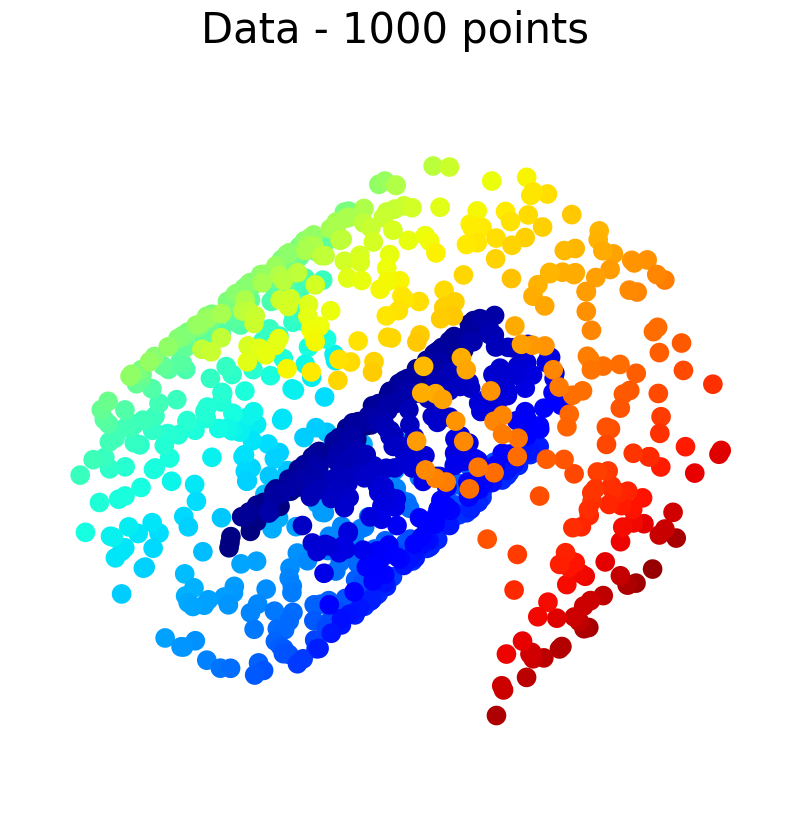

In [139]:
# 示例数据
Data = np.load('./swiss roll-1000.npy')
#np.savetxt('Data.csv', Data, delimiter=',')
# 绘制三维数据集
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Data[0, :], Data[1, :], Data[2, :], c=plt.cm.jet((Data[0, :]**2 + Data[2, :]**2) / 100), s=200, lw=0, alpha=1)
ax.set_xlim(np.min(Data[0, :]), np.max(Data[0, :]))
ax.set_ylim(np.min(Data[1, :]), np.max(Data[1, :]))
ax.set_zlim(np.min(Data[2, :]), np.max(Data[2, :]))
plt.title('Data - '+ str(Data.shape[1]) + ' points', size=30)
ax.axis("off")

In [140]:
# 将 X 格式化为 (n_samples, n_features)
Data_T = np.transpose(Data)
#np.savetxt('Data_T.csv', Data_T, delimiter=',')

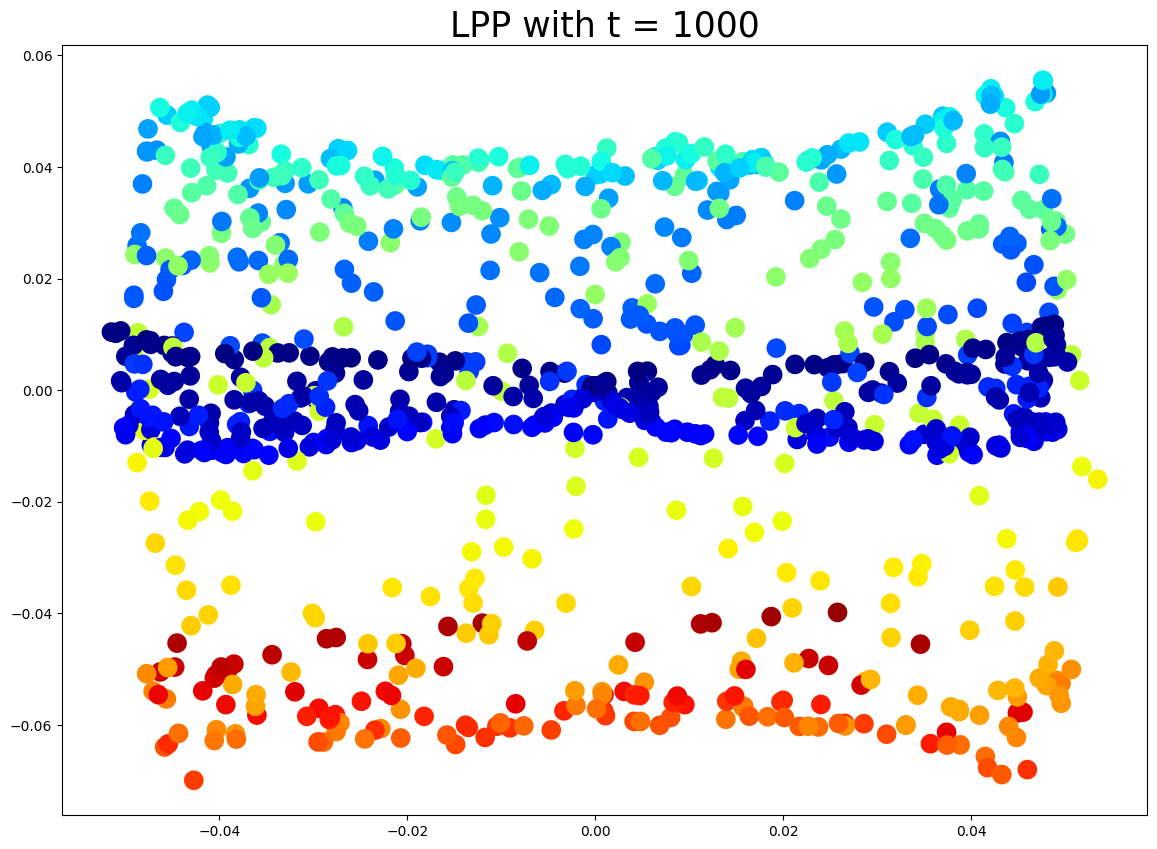

<Figure size 1400x1000 with 0 Axes>

In [141]:
# 绘制及保存投影图
if not os.path.exists('output'):
    os.makedirs('output')
for method in ['epsilon', 'knn']:
    plt.figure(figsize=(14, 10))
    if method == 'epsilon':
        t = 1000
        lpp_embeddings = LPP(Data_T, n_components=2, method=method, n_neighbors=150, t=t)
        plt.title('LPP with t = ' + str(t), size=25)
        file_name = 'LPP_epsilon_t = ' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    elif method == 'knn':
        n_neighbors = 150
        '''
        t = 60
        lpp_embeddings = LPP(Data_T, n_components=2, method=method, n_neighbors=n_neighbors, t=t)
        plt.title('LPP with k-Nearest Neighbors = ' + str(n_neighbors) + ' and t = ' + str(t), size=25)
        file_name = 'LPP_knn_' + str(n_neighbors) + '_t=' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
        '''
    plt.show()


In [142]:
'''
# 设置 epsilon 和 t 的范围和步长。epsilon_range从6.5到8，每次变化0.01，t_range从15到20，每次变化0.1
epsilon_range = np.arange(6.5, 8, 0.01)
t_range = np.arange(15, 20, 0.1)

# 循环遍历不同的 epsilon 和 t
for epsilon in epsilon_range:
    for t in t_range:
        # 执行 LPP 算法
        lpp_embeddings = LPP(Data_T, n_neighbors=n_neighbors, n_components=n_components, method=method, epsilon=epsilon, t=t)
        # 绘制投影图
        plt.figure(figsize=(14,10))
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)
        plt.title('LPP with epsilon = ' + str(epsilon) + ' and t = ' + str(t), size=25)
        file_name = 'LPP_epsilon_' + str(epsilon) + '_t_' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.savefig(file_path)
        plt.close()
'''

"\n# 设置 epsilon 和 t 的范围和步长。epsilon_range从6.5到8，每次变化0.01，t_range从15到20，每次变化0.1\nepsilon_range = np.arange(6.5, 8, 0.01)\nt_range = np.arange(15, 20, 0.1)\n\n# 循环遍历不同的 epsilon 和 t\nfor epsilon in epsilon_range:\n    for t in t_range:\n        # 执行 LPP 算法\n        lpp_embeddings = LPP(Data_T, n_neighbors=n_neighbors, n_components=n_components, method=method, epsilon=epsilon, t=t)\n        # 绘制投影图\n        plt.figure(figsize=(14,10))\n        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)\n        plt.title('LPP with epsilon = ' + str(epsilon) + ' and t = ' + str(t), size=25)\n        file_name = 'LPP_epsilon_' + str(epsilon) + '_t_' + str(t) + '.png'\n        file_path = os.path.join('.', 'output', file_name)\n        plt.savefig(file_path)\n        plt.close()\n"

In [143]:
'''
import pandas as pd
if method == 'knn':
    csvs = ['Data.csv', 'Data_T.csv', 'dist_matrix.csv', 'knn_matrix.csv', 'Weight_matrix.csv', 'Degree_matrix.csv', 'Laplacian_matrix.csv','eigenvalues.csv', 'eigenvectors.csv', 'selected_eigenvectors.csv']
    for csv in csvs:
        df = pd.read_csv(csv, header=None)
        dimension = df.shape
        print(f"Dimension of {csv}: {dimension}")
elif method == 'epsilon':
    csvs = ['Data.csv', 'Data_T.csv', 'Weight_matrix.csv', 'Degree_matrix.csv', 'Laplacian_matrix.csv','eigenvalues.csv', 'eigenvectors.csv', 'selected_eigenvectors.csv']
    for csv in csvs:
        df = pd.read_csv(csv, header=None)
        dimension = df.shape
        print(f"Dimension of {csv}: {dimension}")
'''

'\nimport pandas as pd\nif method == \'knn\':\n    csvs = [\'Data.csv\', \'Data_T.csv\', \'dist_matrix.csv\', \'knn_matrix.csv\', \'Weight_matrix.csv\', \'Degree_matrix.csv\', \'Laplacian_matrix.csv\',\'eigenvalues.csv\', \'eigenvectors.csv\', \'selected_eigenvectors.csv\']\n    for csv in csvs:\n        df = pd.read_csv(csv, header=None)\n        dimension = df.shape\n        print(f"Dimension of {csv}: {dimension}")\nelif method == \'epsilon\':\n    csvs = [\'Data.csv\', \'Data_T.csv\', \'Weight_matrix.csv\', \'Degree_matrix.csv\', \'Laplacian_matrix.csv\',\'eigenvalues.csv\', \'eigenvectors.csv\', \'selected_eigenvectors.csv\']\n    for csv in csvs:\n        df = pd.read_csv(csv, header=None)\n        dimension = df.shape\n        print(f"Dimension of {csv}: {dimension}")\n'

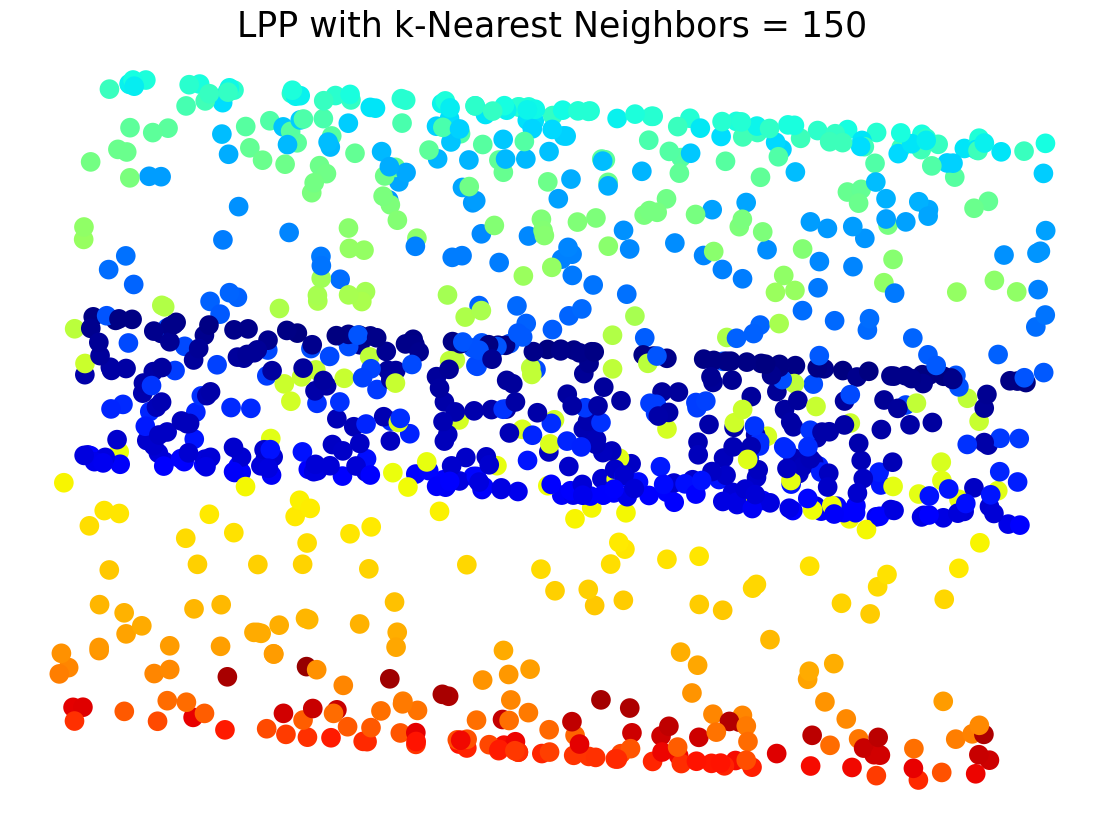

In [144]:
from lpproj import LocalityPreservingProjection
#创建 LPP 模型
lpp = LocalityPreservingProjection(n_neighbors=n_neighbors, n_components= 2)
# 使用 LPP 模型拟合瑞士卷数据集
lpp.fit(Data_T)
# 将数据集进行降维处理
y = lpp.transform(Data_T)

# 绘制投影图
plt.figure(figsize=(14,10))
plt.scatter(y[:, 0], y[:, 1], c=plt.cm.jet((Data_T[:,0]**2+Data_T[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('LPP with k-Nearest Neighbors = ' + str(n_neighbors), size=25)
plt.axis("off")
plt.show()